# Visualizing variant calling metrics in Loxodes magnus MAC vs MIC

Aims
 * Verify that the Loxodes magnus strain sequenced is heterozygous diploid
 * Show that MAC and MIC libraries have the same variants

Produce plots of the following:
 * Counts of numbers of variants per site (2,3,..), but filter out variants with counts < 5
 * Plot allele coverage (ref vs alt) for MIC and MAC separately
 * Plot allele coverage ratio for MIC vs MAC

In [4]:
%%bash
# Extract allele counts, genotype, and binomial probability fields from VCF
set -e
source activate /ebio/abt2_projects/ag-swart-loxodes/envs/variants
#VCF=illumina_comb_scaffold_291.naive_calls.q20.vcf
VCF=../variants/whatshap.freebayes.naive.LmagMAC.g400.no_overlap_repeats.phased.vcf.gz
PREFIX=${VCF%%.vcf.gz}
bcftools query -f '[%CHROM\t%POS\t%SAMPLE\t%AD\t%GT\t%PBINOM(AD)\n]' $VCF > $PREFIX.extract.tsv

Ideas for plot:

scatterplot coverage ratio for ref vs. alternative allele for MIC (x-axis) vs MAC (y-axis) + marginal histograms

Histograms or scatterplots of coverage ratios for MIC and MAC separately, for indels with 

In [8]:
%%bash
head ../variants/whatshap.freebayes.naive.LmagMAC.g400.no_overlap_repeats.phased.extract.tsv

000000F	10	mac	20,1	0/0	0
000000F	10	mic	17,1	0/0	0
000000F	14	mac	31,0	0/0	0
000000F	14	mic	28,1	0/0	0
000000F	28	mac	69,5	0/0	0
000000F	28	mic	70,1	0/0	0
000000F	46	mac	105,2	0/0	0
000000F	46	mic	105,6	0/0	0
000000F	50	mac	105,4	0/0	0
000000F	50	mic	114,0	0/0	0


In [9]:
import re
import json

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import defaultdict

In [10]:
# Read variants table into data frame
var_tbl = []
with open('../variants/whatshap.freebayes.naive.LmagMAC.g400.no_overlap_repeats.phased.extract.tsv','r') as fh:
    for line in fh:
        var_tbl.append(line.rstrip().split("\t"))
var_df = pd.DataFrame(var_tbl, columns=['chrom','pos','lib','ad','gt','pbinom'])

In [13]:
# Count number of variants
var_df['num_vars'] = var_df['ad'].apply(lambda x: len(x.split(',')))
# Count number of variants counted at least 5 times
var_df['num_vars_gt5'] = var_df['ad'].apply(lambda x: len([i for i in x.split(',') if i != '.' and int(i) >=5]))

In [15]:
var_df.head()

,chrom,pos,lib,ad,gt,pbinom,num_vars,num_vars_gt5
0,000000F,10,mac,"20,1",0/0,0,2,1
1,000000F,10,mic,"17,1",0/0,0,2,1
2,000000F,14,mac,"31,0",0/0,0,2,1
3,000000F,14,mic,"28,1",0/0,0,2,1
4,000000F,28,mac,"69,5",0/0,0,2,2


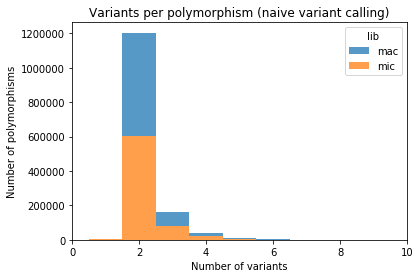

In [26]:
# Histogram of number of variants detected per site
plt.figure(figsize=(6,4))
sns.histplot(
    data=var_df, x='num_vars',
    discrete=True, linewidth=0,
    hue='lib', multiple='stack')
plt.xlim(0,10)
plt.xlabel("Number of variants")
plt.ylabel("Number of polymorphisms")
plt.title("Variants per polymorphism (naive variant calling)")

plt.savefig("plots/variants.naive.num_vars_per_polymorph.png")
plt.savefig("plots/variants.naive.num_vars_per_polymorph.pdf")

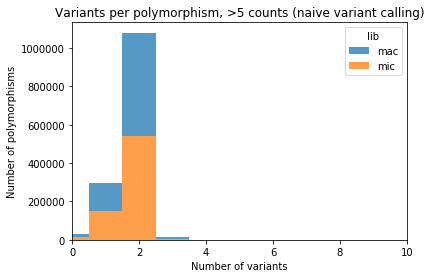

In [25]:
# Histogram of variants detected, minimum 5 observations
plt.figure(figsize=(6,4))
sns.histplot(
    data=var_df, x='num_vars_gt5',
    discrete=True, linewidth=0,
    hue='lib', multiple='stack')
plt.xlim(0,10)
plt.xlabel("Number of variants")
plt.ylabel("Number of polymorphisms")
plt.title("Variants per polymorphism, >5 counts (naive variant calling)")

plt.savefig("plots/variants.naive.num_vars_per_polymorph.min5.png")
plt.savefig("plots/variants.naive.num_vars_per_polymorph.min5.pdf")

In [27]:
# `errors='coerce'` converts non-numeric values to NaN (there are some '.' values)
var_df['pbinom'] = pd.to_numeric(var_df['pbinom'], errors='coerce')

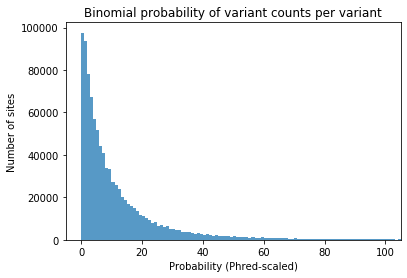

In [66]:
# drop 0 values because homozygous sites also coded as 0
plt.figure(figsize=(6,4))
sns.histplot(
    var_df.query('pbinom>0')['pbinom'],
    binwidth=1, linewidth=0)
plt.xlim(-5,105)
plt.xlabel("Probability (Phred-scaled)")
plt.ylabel("Number of sites")
plt.title("Binomial probability of variant counts per variant")

plt.savefig('plots/variants.naive.binom_prob_histogram.png')
plt.savefig('plots/variants.naive.binom_prob_histogram.pdf')

In [56]:
var_df.head()

,chrom,pos,lib,ad,gt,pbinom,num_vars,num_vars_gt5
0,000000F,10,mac,"20,1",0/0,0.0,2,1
1,000000F,10,mic,"17,1",0/0,0.0,2,1
2,000000F,14,mac,"31,0",0/0,0.0,2,1
3,000000F,14,mic,"28,1",0/0,0.0,2,1
4,000000F,28,mac,"69,5",0/0,0.0,2,2


In [57]:
two_df = var_df.query('num_vars == 2').copy()

In [58]:
two_df[['a1','a2']] = two_df['ad'].str.split(',', expand=True)

In [59]:
two_df['a1'] = pd.to_numeric(two_df['a1'])
two_df['a2'] = pd.to_numeric(two_df['a2'])
two_df['a1a2_ratio'] = two_df['a1'] / two_df['a2']

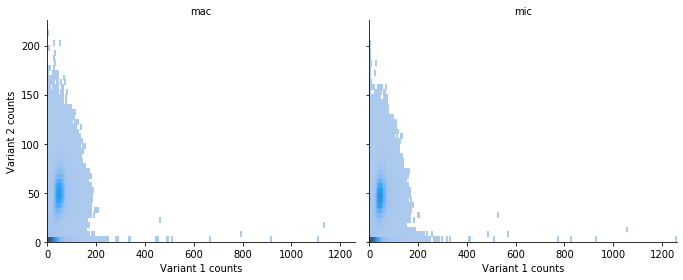

In [67]:
g = sns.FacetGrid(data=two_df, col='lib', height=4, aspect=1.2)
g.map(sns.histplot, 'a1','a2', binwidth=5)
g.set_xlabels("Variant 1 counts")
g.set_ylabels("Variant 2 counts")
g.set_titles(col_template="{col_name}")

plt.savefig('plots/variants.naive.var1_vs_var2_counts.facet_nuclei.png')
plt.savefig('plots/variants.naive.var1_vs_var2_counts.facet_nuclei.pdf')

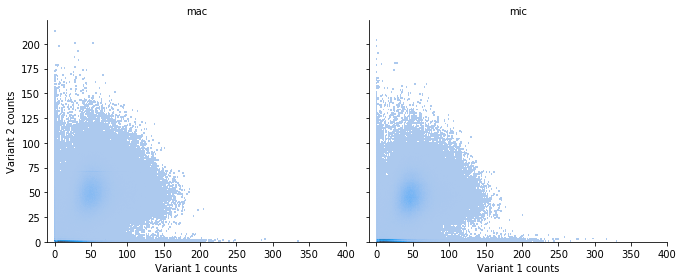

In [68]:
g = sns.FacetGrid(data=two_df.query('a1 < 400'), col='lib', height=4, aspect=1.2, xlim=(-10,400))
g.map(sns.histplot, 'a1','a2')
g.set_xlabels("Variant 1 counts")
g.set_ylabels("Variant 2 counts")
g.set_titles(col_template="{col_name}")

plt.savefig('plots/variants.naive.var1_vs_var2_counts.facet_nuclei.detail.png')
plt.savefig('plots/variants.naive.var1_vs_var2_counts.facet_nuclei.detail.pdf')

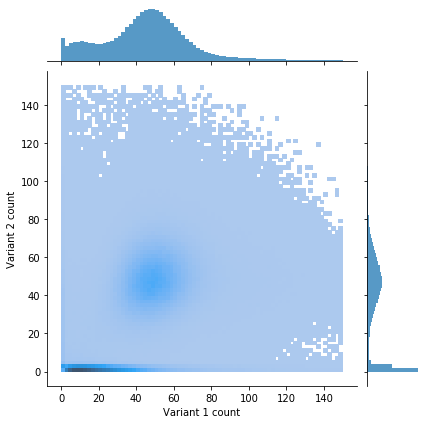

In [69]:
g = sns.JointGrid(
    data=two_df.query('a1<150 & a2 <150'), x='a1', y='a2', 
    height=6)
g.plot_joint(sns.histplot, binwidth=2)
g.plot_marginals(sns.histplot, binwidth=2, linewidth=0)
g.set_axis_labels(xlabel="Variant 1 count", ylabel="Variant 2 count")

plt.savefig('plots/variants.naive.var1_vs_var2_counts.facet_nuclei.combined.detail.png')
plt.savefig('plots/variants.naive.var1_vs_var2_counts.facet_nuclei.combined.detail.pdf')

In [64]:
# Need unique ID field as index for pivoting
two_df['id'] = two_df['chrom'] + "_" + two_df['pos']
two_df_ratios = two_df.pivot(index='id', columns='lib', values='a1a2_ratio').copy().reset_index()
# drop infinity and zero values
two_df_ratios = two_df_ratios.replace([np.inf, -np.inf, 0], np.nan).dropna()

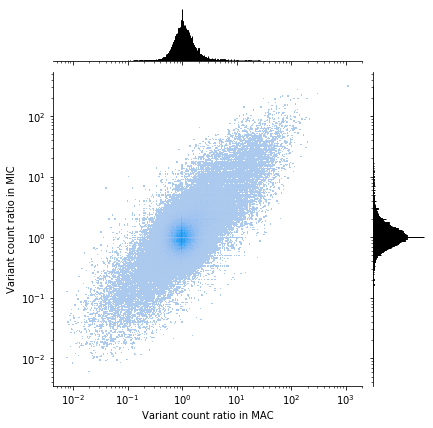

In [70]:
g = sns.JointGrid(data=two_df_ratios, x='mac',y='mic', height=6)
g.plot_joint(sns.histplot, log_scale=(True,True))
g.plot_marginals(sns.histplot)
g.set_axis_labels(xlabel="Variant count ratio in MAC", ylabel="Variant count ratio in MIC")

plt.savefig('plots/variants.naive.variant_count_ratio.mic_vs_mac.png')
plt.savefig('plots/variants.naive.variant_count_ratio.mic_vs_mac.pdf')